In [1]:
# Importamos librerias
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

sns.set()

In [2]:
df = pd.read_csv('train.csv')
df_original = df.copy()

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Tratamiento de los datos inicial

In [3]:
# Eliminamos el NaN encontrado
df = df.dropna(subset=['Electrical'])

# Los demás NaN los convertimos a 0
df = df.fillna(0)

# Ponemos el Id como indice para que no nos de problemas mas adelante
df = df.set_index('Id',drop=True)

# Obtenemos una columna binaria que nos indique si la casa ah sido remodelada
df['Remodelacion'] = df.YearRemodAdd == df.YearBuilt
df['Remodelacion'] = df['Remodelacion'].astype('str')
df['Remodelacion'] = df['Remodelacion'].replace({'True':0,'False':1})

# Obtenemos una columna binaria que nos indique si tiene o no Aire Acondicionado
df['CentralAir'] = df['CentralAir'].replace({'N':0,'Y':1})

df_col_binarias = ['Remodelacion','CentralAir']

# Obtenemos una columna con los años de haber sido construida la casa
df['AñosConstruidos'] = 2021 - df['YearBuilt']
# Obtenemos una columna con los años de haber sido remodelada la casa
df['AñosRemodelacion'] = 2021 - df['YearRemodAdd']
df['AñosRemodelacion'] = df['AñosRemodelacion'].where(df['Remodelacion']==1,0)
df['AñosRemodelacion']

# Obtenemos en una columna los años de construccion del garaje
df['AñosConstGar']= 2021 - df['GarageYrBlt']
df['AñosConstGar'] = df['AñosConstGar'].replace({2021:0})

# Unificamos datos
# Sumaremos el numero total de baños completos
df['TotBaños'] = df['BsmtFullBath']+df['FullBath']

# Sumaremos el numero total de medios baños
df['TotMedBaño']=df['BsmtHalfBath']+df['HalfBath']

# Sumaremos el total de pies cuadrados de terminacion del sotano
df['TotalBsmFinisSF'] = df['BsmtFinSF1']+df['BsmtFinSF2']

# Sumaremos el total de pies cuadrados de los pisos de la casa
df['TotalFlrSF'] = df['1stFlrSF']+df['2ndFlrSF']

# Eliminamos las columnas sobre las cuales ya ejecutamos alguna transformacion
df.drop(['BsmtFinSF1','BsmtFinSF2','1stFlrSF','2ndFlrSF','GarageYrBlt','BsmtFullBath','FullBath','BsmtHalfBath','HalfBath','MSSubClass','MoSold','YrSold','YearRemodAdd','YearBuilt'],axis=1,inplace=True)

# Transformacion Log del Precio

In [4]:
# aplicamos una trasnformacion logaritmica sobre el precio ya que en el ejercicio anterior habiamos observado que 
# las columnas de 'Años Construccion Casa' y 'Años Construccion Garaje' no tenian una relacion lineal con el precio. 
precio_log = np.log(df['SalePrice'])
df['Log_SalePrice'] = precio_log

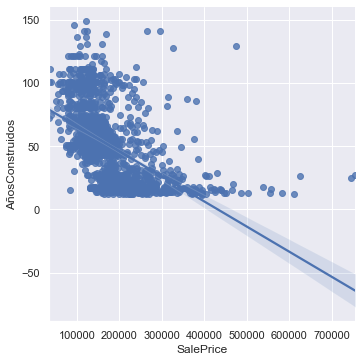

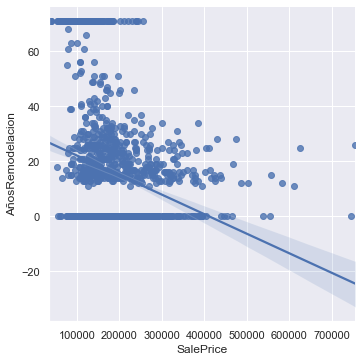

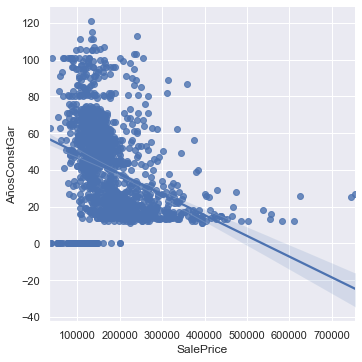

In [5]:
sns.lmplot(data=df,x='SalePrice',y='AñosConstruidos')
sns.lmplot(data=df,x='SalePrice',y='AñosRemodelacion')
sns.lmplot(data=df,x='SalePrice',y='AñosConstGar')

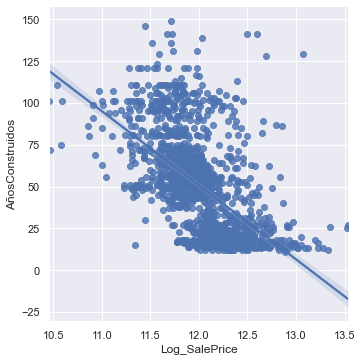

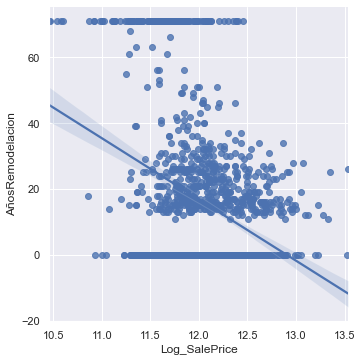

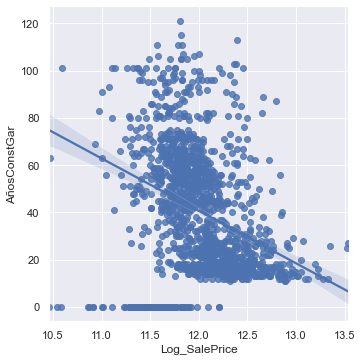

In [6]:
# Asi queda la distribucion posterior a la transformacion logaitmica del precio
sns.lmplot(data=df,x='Log_SalePrice',y='AñosConstruidos')
sns.lmplot(data=df,x='Log_SalePrice',y='AñosRemodelacion')
sns.lmplot(data=df,x='Log_SalePrice',y='AñosConstGar')

In [7]:
# Podemos eliminar la columna de precio original, ya que de momento no nos sirve.
df.drop(['SalePrice'],axis=1,inplace=True)

# Tratamiento de datos numericos

In [8]:
# Analizaremos todos los datos numericos, excepto por el precio (log), y las dos columnas de las cuales sabemos que
# corresponden a variables binarias y tambien aquellas que no consideramos para una normalizacion
no_numeric_columns = ['Log_SalePrice','Remodelacion','CentralAir']

# Queremos solo normalizar las columnas cuyo dato corresponde a una medida de metros cuadrados.
col_to_normalize = ['LotFrontage','LotArea','MasVnrArea','BsmtUnfSF','TotalBsmFinisSF','TotalFlrSF','TotalBsmtSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']

# Tenemos varias columnas con calificaciones, las cuales podemos cambiar de un valor categorico a un numero
columnas_calificacion = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence']

for column in columnas_calificacion:
    df[column] = df[column].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0,'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1,'Gtl':2,'Mod':1,'Sev':0,'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'Gd':4,'Av':3,'Mn':2,'No':1,'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1,'Fin':3,'RFn':2,'Unf':1,'NA':0,'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1})

# Obtenemos los datos numericos en un solo DF
df_numericos = df._get_numeric_data()
df_numericos.drop(no_numeric_columns,axis=1,inplace=True)
df_numericos.head()
columns_numeric = list(df_numericos.columns)

# Iremos obteniendo de una vez los nombres de las columnas que no contienen datos numericos, para poder usarlo mas adelande
# en la obtencion de los dummies
df_no_numericos = df.drop(columns_numeric,axis=1)
df_no_numericos.drop(no_numeric_columns,axis=1,inplace=True)
columns_dummies = list(df_no_numericos.columns)


In [9]:
# para poder realizar una RL buena, tenemos que saber si los datos cumplen con las siguientes caracteristicas:
# 1. Normalidad --> se cumple ya que realizamos una transformacion log en uno de los datos
# 2. Multicolinearidad --> Vamos a revisarlo con el metodo Factor Inflacion de Variacion (VIF)

variables = df_numericos
VIF = pd.DataFrame()
VIF['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
VIF['Variables'] = variables.columns

VIF.head(5)

c:\users\rikrdinii\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Variables
0,4.603086,LotFrontage
1,2.864155,LotArea
2,26.700366,LotShape
3,315.950522,Utilities
4,14.253460,LandSlope


In [10]:
# Este metodo nos indica cuales de las columnas están muy relacionadas unas con otras. 
# Las reglas son las siguientes:
# VIF = 1, no hay multicolinearidad
# 1 < VIF < 5 = se considera buena la multicolinearidad
# 5 a 10 < VIF = hay una multicolinearidad muy grande, por lo que podemos eliminar dicha variable.

vif_to_drop = VIF[VIF['VIF']>5].reset_index(drop=True)
vif_to_drop.head(5)

,VIF,Variables
0,26.700366,LotShape
1,315.950522,Utilities
2,14.253460,LandSlope
3,76.359696,OverallQual
4,43.744661,OverallCond


In [11]:
# Obtuvimos que mas del 50% de las columnas de datos numerico tienen una alta Multicolinearidad, por lo que procedemos a 
# eliminarlas
vif_to_drop = list(vif_to_drop['Variables'])
df = df.drop(vif_to_drop,axis=1)
df.head(5)

,MSZoning,LotFrontage,LotArea,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,...,ScreenPorch,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Remodelacion,AñosRemodelacion,TotMedBaño,Log_SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,8450,Pave,0,Lvl,Inside,CollgCr,Norm,Norm,...,0,0,0,0,WD,Normal,0,0,1,12.247694
2,RL,80.0,9600,Pave,0,Lvl,FR2,Veenker,Feedr,Norm,...,0,0,0,0,WD,Normal,0,0,1,12.109011
3,RL,68.0,11250,Pave,0,Lvl,Inside,CollgCr,Norm,Norm,...,0,0,0,0,WD,Normal,1,19,1,12.317167
4,RL,60.0,9550,Pave,0,Lvl,Corner,Crawfor,Norm,Norm,...,0,0,0,0,WD,Abnorml,1,51,0,11.849398
5,RL,84.0,14260,Pave,0,Lvl,FR2,NoRidge,Norm,Norm,...,0,0,0,0,WD,Normal,0,0,1,12.429216


# Tratamiento de variables Categoricas

In [12]:
# anteriormente habiamos generado el nombre de las columnas que se estarían transformando en Dummies
# Así Que vamos a utilizarla para generar las dimmies y tener nuestro data ya completo

df = pd.get_dummies(data=df,columns=columns_dummies,drop_first=True)
df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtExposure,BsmtFinType2,CentralAir,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,1,1,1,0,61,0,0,...,0,0,0,0,1,0,0,0,1,0
2,80.0,9600,0.0,4,1,1,298,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,68.0,11250,162.0,2,1,1,0,42,0,0,...,0,0,0,0,1,0,0,0,1,0
4,60.0,9550,0.0,1,1,1,0,35,272,0,...,0,0,0,0,1,0,0,0,0,0
5,84.0,14260,350.0,3,1,1,192,84,0,0,...,0,0,0,0,1,0,0,0,1,0


# Prueba de Hipotesis. 
#### Serán nescesarias todas las variables para la prediccion del precio de una casa?

In [13]:
# H0 = Todas las variables son nescesarias para predecir el valor de una casa
# P_Value = 95%
# Se rechazará esta hipotesis nula si nuestro P_Value resulta menor a 0.05

In [14]:
# Para póder hacer esta prueba de hipotesis, lo que haremos es realizar una regresion linear a cada variable contra el precio
# y obtendremos el p_value, posteriormente, si mas del 10% de las variables determinamos que no nos sirven para la prediccion, 
# procederemos a eliminarlas del modelo de regresion lineal
from scipy.stats import linregress
p_hipotesis_1 = df.copy()

def p_value(data,int_confianza):
      
    y = data['Log_SalePrice']
    p_value = []
    for column in data.columns:
        x = data[column]
        slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
        p_value.append((column,pvalue))
    
    p_value_df = pd.DataFrame(p_value,columns=['Variable','P_Value'])
    
    p_value_df['H0'] = p_value_df['P_Value'] <= int_confianza
            
    p_value_df['H0'] = p_value_df['H0'].astype('str')
    p_value_df['H0'].replace({'True':'Valida para Reg Lin','False':'No Valida Reg Lin'},inplace=True)
    
    return p_value_df

# Obtenemos las Variables Utiles para la RL
variables_df = p_value(p_hipotesis_1,0.05)
p_value_rl = variables_df[variables_df['H0']=='Valida para Reg Lin']
p_value_rl=p_value_rl.sort_values(by='P_Value',ascending=False).reset_index(drop=True)

# Obtenemos las variables (Columnas) a sacar de nuesto df
variables_sacar = variables_df[variables_df['H0']=='No Valida Reg Lin']
variables_sacar= variables_sacar['Variable'].to_list()


print('Numero de Variables utiles para RL:',len(p_value_rl))
print('Numero de Variable NO utiles para RL:',len(variables_sacar))
print('Total de variables:',len(p_hipotesis_1.columns))
porcentaje_var_no_utiles = round((len(variables_sacar)/len(p_hipotesis_1.columns))*100,2)
porcentaje_impuesto = 30
if porcentaje_var_no_utiles > porcentaje_impuesto:
    print(f'Porcentaje no util:{porcentaje_var_no_utiles}%,sobrepasa el {porcentaje_impuesto}% planteado para la H0')
else:
    print(f'Porcentaje no util:{porcentaje_var_no_utiles}%,por debajo de {porcentaje_impuesto}% planteado para la H0')

print('')
print('')
print('Variebles utiles para RL:')
p_value_rl[:-1].head(5)

Numero de Variables utiles para RL: 102
Numero de Variable NO utiles para RL: 63
Total de variables: 165
Porcentaje no util:38.18%,sobrepasa el 30% planteado para la H0


Variebles utiles para RL:


,Variable,P_Value,H0
0,Condition1_PosA,0.044803,Valida para Reg Lin
1,RoofMatl_WdShake,0.043087,Valida para Reg Lin
2,Exterior2nd_Wd Shng,0.039323,Valida para Reg Lin
3,Condition2_RRNn,0.037025,Valida para Reg Lin
4,3SsnPorch,0.036007,Valida para Reg Lin


In [15]:
# Eliminamos las columnas a sacar del df
df.drop(variables_sacar,axis=1,inplace=True)
df.head(4)

,LotFrontage,LotArea,MasVnrArea,BsmtExposure,CentralAir,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,MiscFeature_Othr,MiscFeature_Shed,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,1,1,0,61,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,80.0,9600,0.0,4,1,298,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,68.0,11250,162.0,2,1,0,42,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,60.0,9550,0.0,1,1,0,35,272,0,0,...,1,0,1,0,0,0,1,0,0,0


# Regresion Lineal con SKLearn

In [16]:
# para no alterar nuestro df ya con los cambios realizados, lo que haremos es una copia del mismo
df_rl = df.copy()
df_rl.head()

,LotFrontage,LotArea,MasVnrArea,BsmtExposure,CentralAir,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,MiscFeature_Othr,MiscFeature_Shed,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,1,1,0,61,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,80.0,9600,0.0,4,1,298,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,68.0,11250,162.0,2,1,0,42,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,60.0,9550,0.0,1,1,0,35,272,0,0,...,1,0,1,0,0,0,1,0,0,0
5,84.0,14260,350.0,3,1,192,84,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [17]:
objetivo = df_rl['Log_SalePrice']
inputs = df_rl.drop('Log_SalePrice',axis=1)

In [18]:
# Escalamos los datos para tenerlos todos dentro de una sola dimencion (normalizamos). El precio no lo hacemos ya que
# este lo tenemos en una escala logaritmica
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

# Separamos los datos en prueba y testeo considerando para prueba un 80% de los datos y un 20% para las pruebas
# y le colocamos un random de 77 para que siempre nos salgan los mismos datos.
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled,objetivo, test_size = 0.2, random_state = 77)

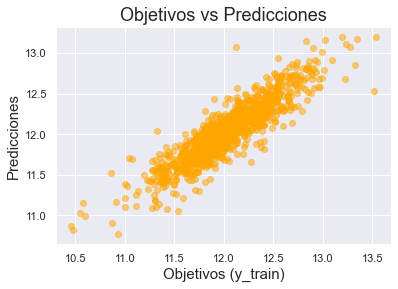

In [19]:
# Para el modelo de Regresion Lineal, usaremos la libreria de sklearn
reg_lineal = LinearRegression()
reg_lineal.fit(x_train,y_train)

predicciones = reg_lineal.predict(x_train)

plt.scatter(y_train,predicciones,alpha=.5,color='orange')
plt.xlabel('Objetivos (y_train)',size=15)
plt.ylabel('Predicciones',size=15)
plt.title('Objetivos vs Predicciones',size=18);
# Por la grafica podemos ver que nuestras predicciones quedaron bastante ajustadas a los datos que ya teniamos.

c:\users\rikrdinii\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


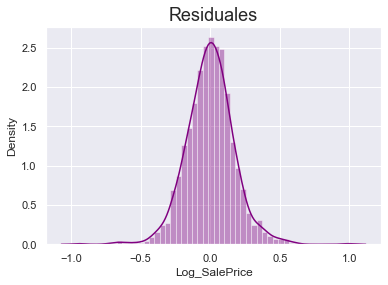

In [20]:
# Vamos a graficar los residuos
sns.distplot(y_train-predicciones,color='purple')
plt.title('Residuales',size=18);
# Vemos que tenemos una distribucion uniforme de los residuos

In [21]:
# Obtenemos el R2 de nuestro modelo. 
r_2 = reg_lineal.score(x_train,y_train)
print(" % de datos explicados con nuestro modelo:",round(r_2*100,2),'%')

 % de datos explicados con nuestro modelo: 81.46 %


In [22]:
# vamos a obtener el resumen
reg_summary = pd.DataFrame(inputs.columns.values,columns=['Factores'])
reg_summary['Valores'] = reg_lineal.coef_
reg_summary.head(5)

,Factores,Valores
0,LotFrontage,0.023865
1,LotArea,0.041675
2,MasVnrArea,0.025869
3,BsmtExposure,0.039225
4,CentralAir,0.038037


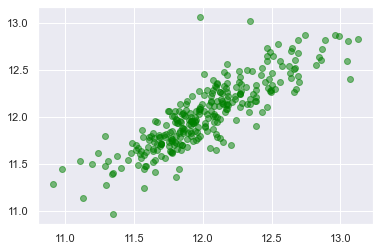

In [23]:
# Vamos a ver las predicciones que podemos hacer
predicciones_test = reg_lineal.predict(x_test)
plt.scatter(y_test,predicciones_test,alpha=0.5,color='green');
# Por la concentracion de los datos, podemos inferir que nuestro modelo es bueno para predecir aquellos precios medios
# mientras que los mas altos y los mas bajos no se tendrá tanta certeza

In [24]:
# Crearemos un DF con los datos objetivo y los datos predichos para poder visualizarlos. 
y_test = y_test.reset_index(drop=True) 
df_predicciones = pd.DataFrame(np.exp(predicciones_test),columns=['Prediccion'])
df_predicciones['Objetivo'] = np.exp(y_test)
df_predicciones['Residual'] = df_predicciones['Objetivo']-df_predicciones['Prediccion'] 
df_predicciones.head(5)

# Podemos observar que hay algunos de los datos en los cuales tuvimos un sobrante y otros algun faltante. 

,Prediccion,Objetivo,Residual
0,207648.543518,213000.0,5351.456482
1,118094.497407,109000.0,-9094.497407
2,114707.520323,179000.0,64292.479677
3,160961.591895,169500.0,8538.408105
4,152193.517740,151500.0,-693.517740


In [25]:
df_predicciones.mean()
# Con esto, podemos observar que en promedio tenemos un precio de venta de: 179,465.72 (Objetivo)
# un promedio de prediccion de: 178,789.31
# una diferencia promedio de: 676.41

# Podemos inferir que nuestro modelo es suficientemente acertado.

Prediccion    178789.313365
Objetivo      179465.729452
Residual         676.416087
dtype: float64

In [26]:
df_predicciones['Dif %'] = round((df_predicciones['Residual']/df_predicciones['Objetivo'])*100,2)
df_predicciones.head(5)

,Prediccion,Objetivo,Residual,Dif %
0,207648.543518,213000.0,5351.456482,2.51
1,118094.497407,109000.0,-9094.497407,-8.34
2,114707.520323,179000.0,64292.479677,35.92
3,160961.591895,169500.0,8538.408105,5.04
4,152193.517740,151500.0,-693.517740,-0.46


# Regresion Lineal OLS

In [27]:
# para no alterar nuestro df ya con los cambios realizados, lo que haremos es una copia del mismo
df_rl_OLS = df.copy()
df_rl_OLS.head(5)

,LotFrontage,LotArea,MasVnrArea,BsmtExposure,CentralAir,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,MiscFeature_Othr,MiscFeature_Shed,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,1,1,0,61,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,80.0,9600,0.0,4,1,298,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,68.0,11250,162.0,2,1,0,42,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,60.0,9550,0.0,1,1,0,35,272,0,0,...,1,0,1,0,0,0,1,0,0,0
5,84.0,14260,350.0,3,1,192,84,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [28]:
# generamos las variables
y = df_rl_OLS['Log_SalePrice']
x1 = df_rl_OLS.drop('Log_SalePrice',axis=1)

# Agregamos la constante
X = sm.add_constant(x1)

# Separamos los datos para poder hacer el entrenamiento y la prueba
x_train_OLS, x_test_OLS, y_train_OLS,y_test_OLS=train_test_split(X,y,test_size=.2,random_state=100)


# Generamos el modelo
linreg_stats = sm.OLS(y_train_OLS, x_train_OLS).fit()

linreg_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Log_SalePrice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     45.97
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          9.28e-319
Time:                        23:39:20   Log-Likelihood:                 386.70
No. Observations:                1167   AIC:                            -573.4
Df Residuals:                    1067   BIC:                            -67.17
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.0279      0.153     71.844      0.000      10.727      11.329
LotFrontage               0.0007      0.000      3.689      0.000       0.000       0.001
LotArea                2.693e-06   6.67e-07      4.037      0.000    1.38e-06       4e-06
MasVnrArea                0.0001   4.44e-05      3.170      0.002    5.37e-05       0.000
BsmtExposure              0.0361      0.006      5.724      0.000       0.024       0.048
CentralAir                0.1947      0.031      6.375      0.000       0.135       0.255
WoodDeckSF                0.0003   4.94e-05      6.266      0.000       0.000       0.000
OpenPorchSF               0.0006   8.85e-05      6.750      0.000       0.000       0.001
EnclosedPorch             0.0002   9.79e-05      2.364      0.018    3.93e-05       0.000
3SsnPorch                 0.0003      0.000      1.820      0.069   -2.59e-05       0.001
ScreenPorch               0.0003      0.000      3.133      0.002       0.000       0.001
Fence                    -0.0020      0.005     -0.396      0.692      -0.012       0.008
Remodelacion              0.1071      0.017      6.135      0.000       0.073       0.141
AñosRemodelacion         -0.0021      0.000     -4.464      0.000      -0.003      -0.001
TotMedBaño                0.0290      0.013      2.179      0.030       0.003       0.055
MSZoning_FV               0.4103      0.098      4.166      0.000       0.217       0.604
MSZoning_RH               0.5017      0.102      4.933      0.000       0.302       0.701
MSZoning_RL               0.4623      0.084      5.530      0.000       0.298       0.626
MSZoning_RM               0.4042      0.079      5.095      0.000       0.249       0.560
Street_Pave               0.0730      0.086      0.850      0.395      -0.095       0.241
Alley_Grvl               -0.0482      0.034     -1.402      0.161      -0.116       0.019
LandContour_HLS           0.0078      0.034      0.226      0.821      -0.060       0.075
LotConfig_CulDSac         0.0748      0.026      2.889      0.004       0.024       0.126
LotConfig_Inside         -0.0045      0.014     -0.325      0.745      -0.031       0.022
Neighborhood_BrDale      -0.2144      0.070     -3.051      0.002      -0.352      -0.076
Neighborhood_BrkSide     -0.0441      0.043     -1.017      0.309      -0.129       0.041
Neighborhood_ClearCr      0.0205      0.047      0.433      0.665      -0.072       0.113
Neighborhood_CollgCr      0.0439      0.027      1.651      0.099      -0.008       0.096
Neighborhood_Crawfor      0.2009      0.039      5.186      0.000       0.125       0.277
Neighborhood_Edwards     -0.1440      0.030     -4.760      0.000      -0.203      -0.085
Neighborhood_Gilbert      0.0109      0.032      0.343      0.732      -0.052       0.073
Neighborhood_IDOTRR    

In [29]:
# Podemos Observar que obtenemos una R2 casi identica a la anterior, 
# por lo que asumismos que el trabajo está bien realizado.

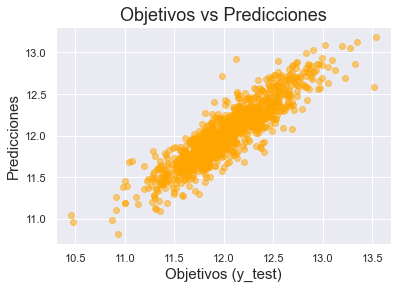

In [30]:
# Hacemos una prediccion con los datos de prueba y los graficamos

prediccion_OLS_train = linreg_stats.predict(x_train_OLS)
plt.scatter(y_train_OLS,prediccion_OLS_train,alpha=.5,color='orange')
plt.xlabel('Objetivos (y_test)',size=15)
plt.ylabel('Predicciones',size=15)
plt.title('Objetivos vs Predicciones',size=18);


# Nuevamente podemos ver que nuestro modelo predice bastante bien los datos con precios no tan altos o bajos. 
# entre mas extremo sea nuestro precio menos eficiente será el modelo. 

c:\users\rikrdinii\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


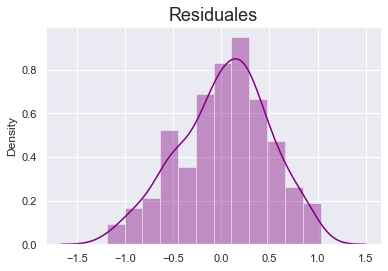

In [31]:
# Vamos a graficar los residuos
x_test_OLS=x_test_OLS.reset_index(drop=True)
y_test_OLS= y_test_OLS.reset_index(drop=True)

# Hacemos las predicciones con el de prueba
prediccion_OLS = linreg_stats.predict(x_test_OLS)

sns.distplot(y_train_OLS-prediccion_OLS,color='purple')
plt.title('Residuales',size=18);
# A diferencia del modelo anterior, tenemos una distribucion ligeramente sesgada a la derecha

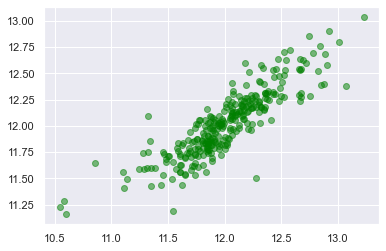

In [32]:
plt.scatter(y_test_OLS,prediccion_OLS,alpha=0.5,color='green');
# Por la concentracion de los datos, podemos inferir que nuestro modelo es bueno para predecir aquellos precios medios
# mientras que los mas altos y los mas bajos no se tendrá tanta certeza

In [33]:
# Hacemos nuestra tabla para tener los datos concentrados
predicciones_OLS = pd.DataFrame({'Objetivo':y_test_OLS,'Prediccion':round(prediccion_OLS,2)}).reset_index(drop=True)
predicciones_OLS['Residual'] = predicciones_OLS.Objetivo - predicciones_OLS.Prediccion
predicciones_OLS['Dif %'] = round((predicciones_OLS['Residual']/predicciones_OLS['Objetivo'])*100,2)
df_predicciones.head(5)

,Prediccion,Objetivo,Residual,Dif %
0,207648.543518,213000.0,5351.456482,2.51
1,118094.497407,109000.0,-9094.497407,-8.34
2,114707.520323,179000.0,64292.479677,35.92
3,160961.591895,169500.0,8538.408105,5.04
4,152193.517740,151500.0,-693.517740,-0.46


In [34]:
df_predicciones.mean()
# Con esto, podemos observar que en promedio tenemos un precio de venta de: 179,465.72 (Objetivo)
# un promedio de prediccion de: 178,789.31
# una diferencia promedio de: -2.84

# Podemos inferir que nuestro modelo es suficientemente acertado

Prediccion    178789.313365
Objetivo      179465.729452
Residual         676.416087
Dif %             -2.848390
dtype: float64